In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from skopt.space import Real, Integer, Categorical
import shap
import lime
from matplotlib.patches import Rectangle
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

shap.initjs()

c:\Users\shakt\miniconda3\envs\tf210-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing Dataset

In [2]:
df = pd.read_csv('data/Bioinspired composite_loading-25.csv')
df.head()

,Loading Type,Constraint,Number of Layer,E1/E2,a/h,Configuration,Deflection
0,UDL,CCCC,12,10,10,HR1,0.565981
1,UDL,CCCC,12,10,10,HR2,0.587974
2,UDL,CCCC,12,10,10,HR3,0.617162
3,UDL,CCCC,12,10,10,HE1,0.560205
4,UDL,CCCC,12,10,10,HE2,0.565093


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Loading Type     672 non-null    object 
 1   Constraint       672 non-null    object 
 2   Number of Layer  672 non-null    int64  
 3   E1/E2            672 non-null    int64  
 4   a/h              672 non-null    int64  
 5   Configuration    672 non-null    object 
 6   Deflection       672 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 36.9+ KB


## One hot encoding of categorical variable columns

In [4]:
to_encode = df[['Loading Type', 'Constraint', 'Configuration']]
to_encode.shape

(672, 3)

In [5]:
y = df['Deflection '] 
df.drop(['Loading Type','Configuration', 'Constraint', 'Deflection '], axis=1, inplace=True)
df.head(20)

,Number of Layer,E1/E2,a/h
0,12,10,10
1,12,10,10
2,12,10,10
3,12,10,10
4,12,10,10
5,12,10,10
6,12,10,10
7,12,10,10
8,12,10,10
9,12,10,10


In [6]:
to_encode.columns

Index(['Loading Type', 'Constraint', 'Configuration'], dtype='object')

In [7]:
encoded = pd.get_dummies(to_encode, dtype=int)
encoded = encoded.astype(int)
encoded.shape

(672, 18)

In [8]:
encoded.sample(5)

,Loading Type_SSL,Loading Type_UDL,Constraint_CCCC,Constraint_SSSS,Configuration_FH,Configuration_HE1,Configuration_HE2,Configuration_HE3,Configuration_HR1,Configuration_HR2,Configuration_HR3,Configuration_HS1,Configuration_HS2,Configuration_HS3,Configuration_LH1,Configuration_LH2,Configuration_LH3,Configuration_QI
264,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
296,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
153,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
396,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
64,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [9]:
# Concat data_rough, x
df_processed = pd.concat([df, encoded.iloc[:,0], encoded.iloc[:,2], encoded.iloc[:,4:17], y], axis=1)
df_processed.shape

(672, 19)

In [10]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Number of Layer    672 non-null    int64  
 1   E1/E2              672 non-null    int64  
 2   a/h                672 non-null    int64  
 3   Loading Type_SSL   672 non-null    int32  
 4   Constraint_CCCC    672 non-null    int32  
 5   Configuration_FH   672 non-null    int32  
 6   Configuration_HE1  672 non-null    int32  
 7   Configuration_HE2  672 non-null    int32  
 8   Configuration_HE3  672 non-null    int32  
 9   Configuration_HR1  672 non-null    int32  
 10  Configuration_HR2  672 non-null    int32  
 11  Configuration_HR3  672 non-null    int32  
 12  Configuration_HS1  672 non-null    int32  
 13  Configuration_HS2  672 non-null    int32  
 14  Configuration_HS3  672 non-null    int32  
 15  Configuration_LH1  672 non-null    int32  
 16  Configuration_LH2  672 non

## Run the workflow for building regressor models and saving the best hyperparameters and results

In [11]:
# Define models
models = {
    "Linear": LinearRegression(),  # No hyperparameters to optimize
    "SVR": SVR(),
    "GBR": GradientBoostingRegressor(),
    "RFR": RandomForestRegressor(),
    "XGBR": XGBRegressor(),
    "NeuralNetwork": None  # NN model will be dynamically created in the workflow
}

In [12]:
# Define hyperparameter spaces for optimization
param_spaces = {
    "SVR": {
        "C": Real(0.1, 10.0),        # Regularization parameter
        "epsilon": Real(0.01, 1.0),  # Epsilon-tube within which no penalty is associated
        "kernel": Categorical(["linear", "rbf"])
    },
    "GBR": {
        "n_estimators": Integer(3, 10),   # Number of boosting stages
        "loss": Categorical(['squared_error', 'absolute_error', 'huber', 'quantile']), # Loss function to be optimized
        "learning_rate": Real(0.005, 0.9),   # Step size shrinkage
        "alpha": Real(0.005, 0.9, prior="log-uniform"), # alpha-quantile of the huber and quantile loss function
        "max_depth": Integer(3, 10)         # Maximum depth of each tree
    },
    "RFR": {
        "n_estimators": Integer(3, 10),   # Number of trees
        "max_depth": Integer(3, 10)         # Maximum depth of trees
    },
    "XGBR": {
        "n_estimators": Integer(3, 10),   # Number of trees
        "learning_rate": Real(0.005, 0.9),   # Learning rate
        "max_depth": Integer(3, 10)         # Maximum depth of trees
    },
    "NeuralNetwork": {
        "hidden_layers": Integer(1, 3),     # Number of hidden layers
        "units": Integer(32, 128),          # Number of units per layer
        "activation": Categorical(['relu', 'tanh']),  # Activation function
        "learning_rate": Real(1e-6, 1e-2, prior='log-uniform')  # Learning rate
    }
}

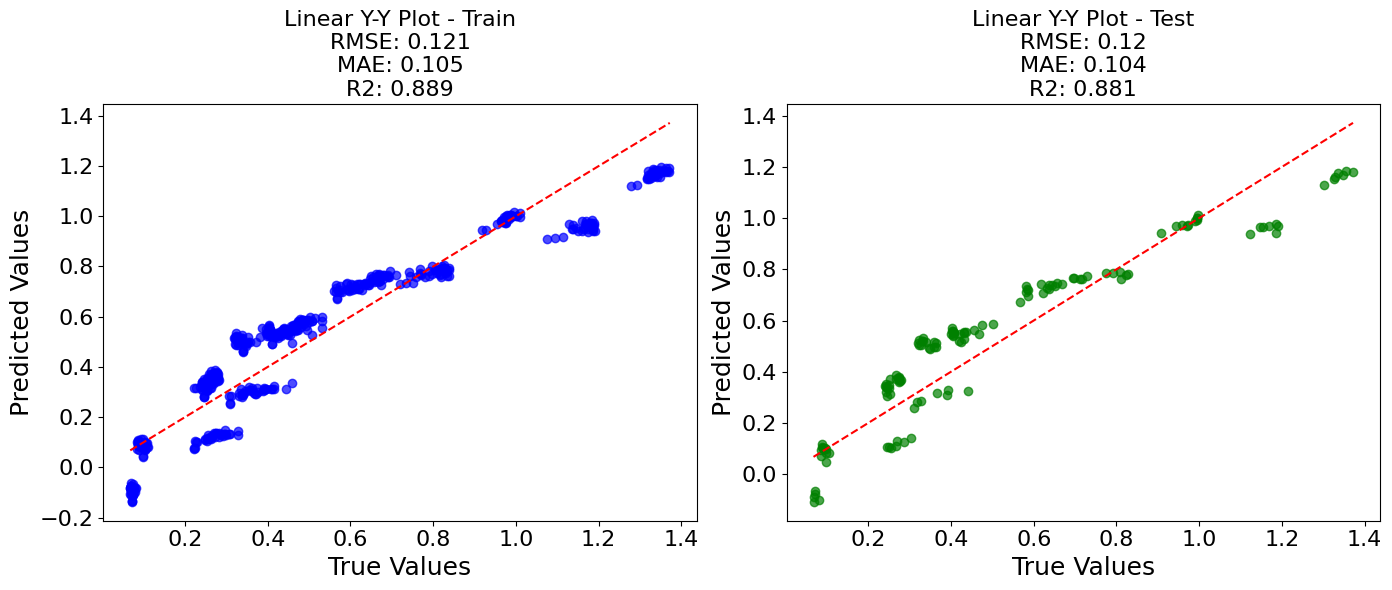

Plot saved for Linear: plots\Linear_yy_plot.png


c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

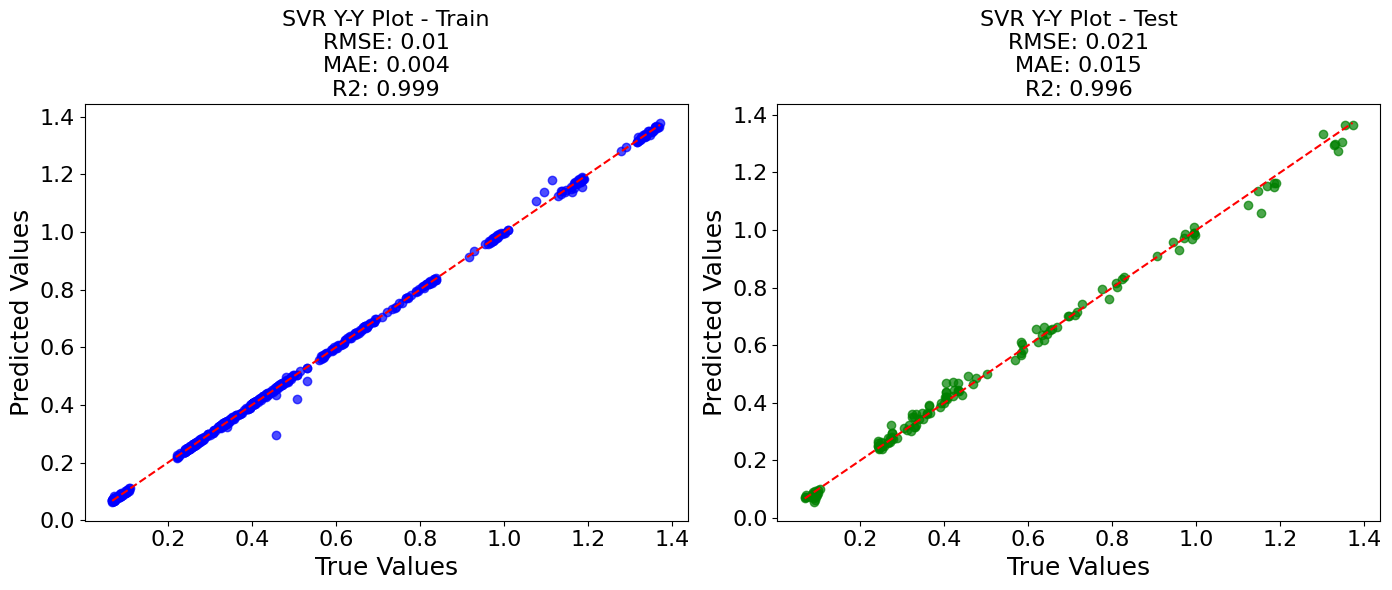

Plot saved for SVR: plots\SVR_yy_plot.png


c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


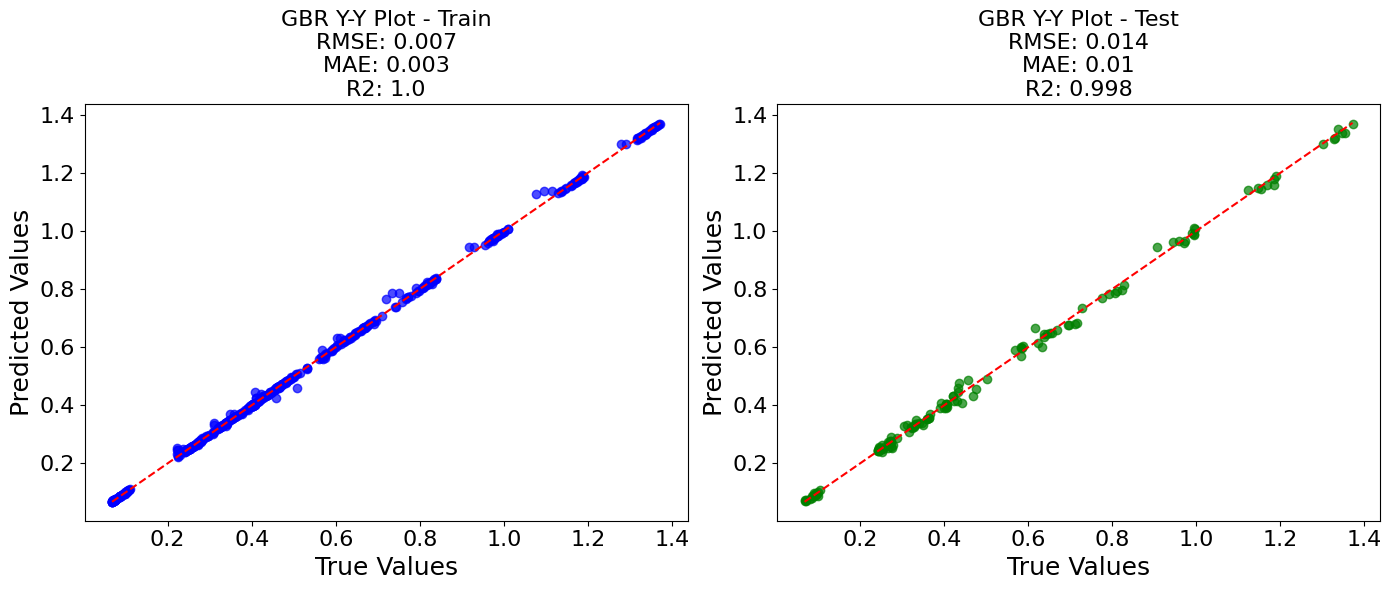

Plot saved for GBR: plots\GBR_yy_plot.png


c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\miniconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

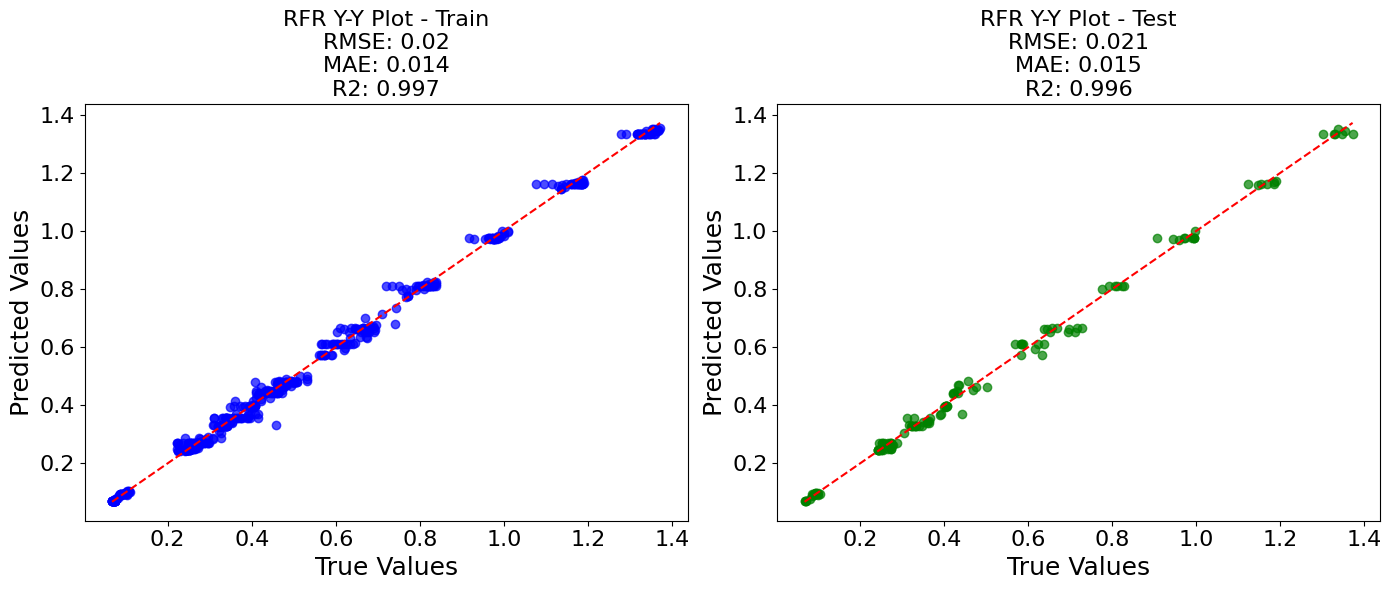

Plot saved for RFR: plots\RFR_yy_plot.png


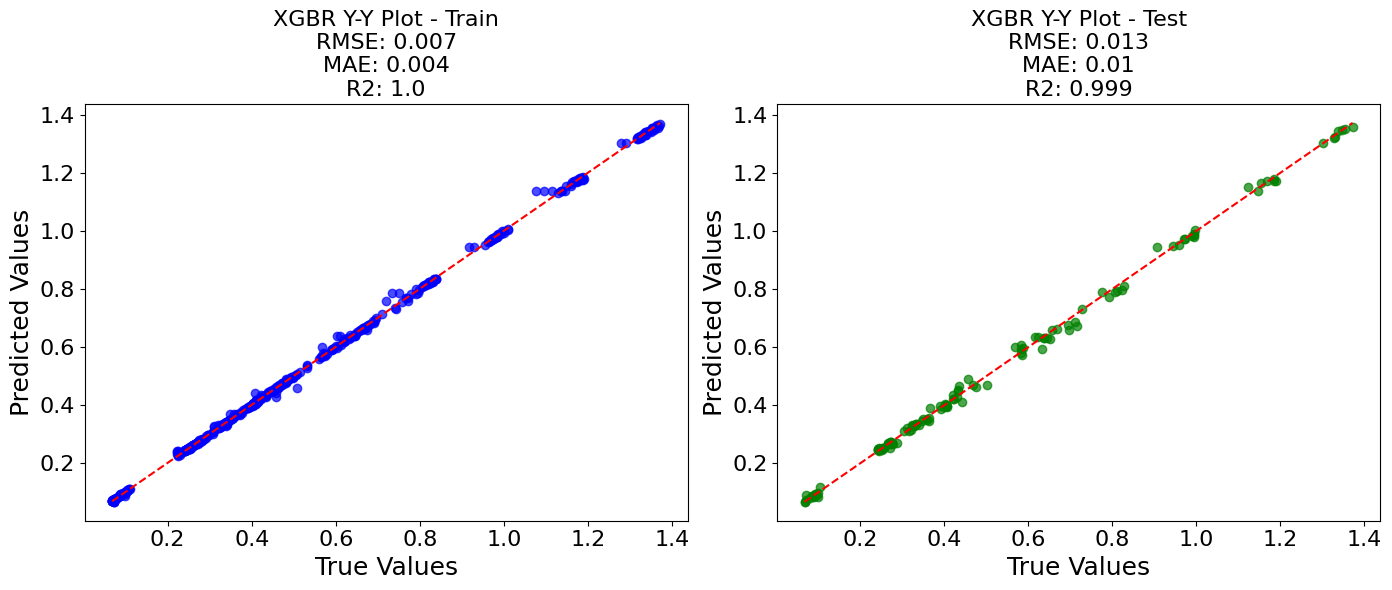

Plot saved for XGBR: plots\XGBR_yy_plot.png
5/5 [==============================] - 0s 1ms/step


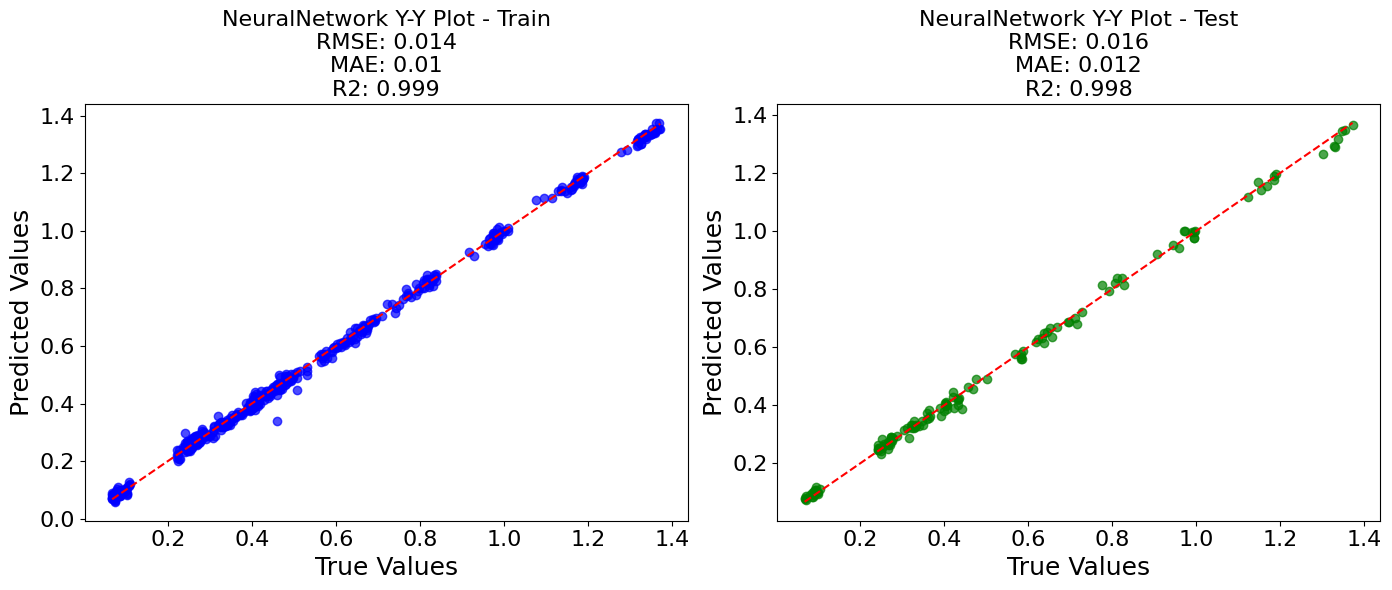

Plot saved for NeuralNetwork: plots\NeuralNetwork_yy_plot.png
Results saved to results.csv
           Model                                        Best Params  Train R2  \
0         Linear                                                 {}     0.889   
1            SVR  {'C': 8.747393367080921, 'epsilon': 0.01, 'ker...     0.999   
2            GBR  {'n_estimators': 8, 'loss': 'squared_error', '...     1.000   
3            RFR                {'n_estimators': 5, 'max_depth': 6}     0.997   
4           XGBR  {'n_estimators': 10, 'learning_rate': 0.722550...     1.000   
5  NeuralNetwork  {'hidden_layers': 1, 'units': 128, 'activation...     0.999   

   Train MAE  Train RMSE  Test R2  Test MAE  Test RMSE  
0      0.105       0.121    0.881     0.104      0.120  
1      0.004       0.010    0.996     0.015      0.021  
2      0.003       0.007    0.998     0.010      0.014  
3      0.014       0.020    0.996     0.015      0.021  
4      0.004       0.007    0.999     0.010      0.013  

In [13]:
# Import the run_workflow function from workflow.py
from mlregworkflow import run_workflow

# Split the data into features (X) and response (y)
X = np.array(df_processed.iloc[:,:-1])
y = np.array(df_processed.iloc[:,-1])
# Convert y to 2D array if it's 1D
# This is necessary for compatibility with some models and functions
if len(y.shape) == 1:
    y = y.reshape(-1, 1)

# Run the workflow
results_df = run_workflow(X, y, models, param_spaces)

# Display the results DataFrame
print(results_df)

## Plotting Metrics of all the Models built

In [11]:
results_df = pd.read_csv('results.csv')
results_df

,Model,Best Params,Train R2,Train MAE,Train RMSE,Test R2,Test MAE,Test RMSE
0,Linear,{},0.889,0.105,0.121,0.881,0.104,0.120
1,SVR,"{'C': 8.747393367080921, 'epsilon': 0.01, 'ker...",0.999,0.004,0.010,0.996,0.015,0.021
2,GBR,"{'n_estimators': 8, 'loss': 'squared_error', '...",1.000,0.003,0.007,0.998,0.010,0.014
3,RFR,"{'n_estimators': 5, 'max_depth': 6}",0.997,0.014,0.020,0.996,0.015,0.021
4,XGBR,"{'n_estimators': 10, 'learning_rate': 0.722550...",1.000,0.004,0.007,0.999,0.010,0.013
5,NeuralNetwork,"{'hidden_layers': 1, 'units': 128, 'activation...",0.999,0.010,0.014,0.998,0.012,0.016


In [12]:
model_names = ['Linear ', 'SVR', 'GBR', 'RFR', 'XGBR', 'NNR']

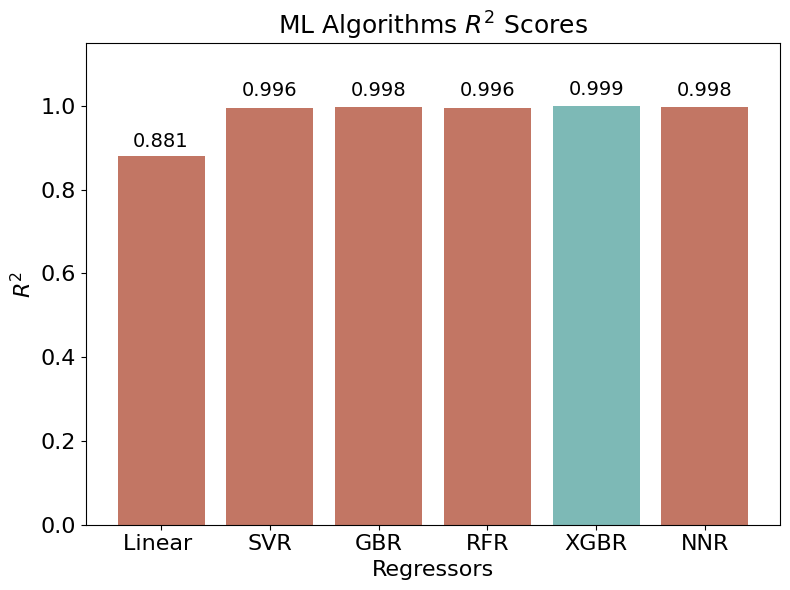

In [13]:
# Plotting R2 of all ML models
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

performance = results_df.iloc[:,5]

bar = ax.bar(model_names, performance,color=np.where(performance == max(performance),'#7DB9B6','#C27664'))
ax.set_xlabel('Regressors', fontsize=16)
ax.set_ylabel('$R^2$', fontsize=16)
ax.set_title('ML Algorithms $R^2$ Scores', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+0.5*rect.get_width(),1.04*height,
                 '%.3f' % height,
                 ha='center', va='center',fontsize=14)
autolabel(bar)

ax.set_ylim(0,1.15)

plt.tight_layout()
plt.show()

fig.savefig('plots/R2 comparison plot.png', dpi=300, bbox_inches='tight')

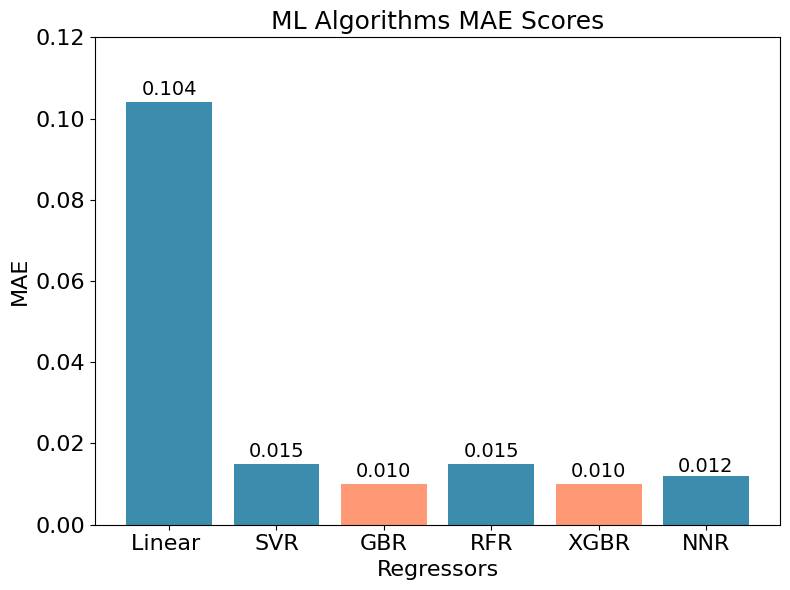

In [14]:
# Plotting MAE of all ML models
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

performance = results_df.iloc[:,6]

bar = ax.bar(model_names, performance,color=np.where(performance == min(performance),'#FF9874','#3C8DAD'))
ax.set_xlabel('Regressors', fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.set_title('ML Algorithms MAE Scores', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if height >=0.01 and height <0.012:
            plt.text(rect.get_x()+0.5*rect.get_width(),1.3*height,'%.3f' % height,ha='center', va='center',fontsize=14)
        elif height >=0.012 and height <0.016:
            plt.text(rect.get_x()+0.5*rect.get_width(),1.2*height,'%.3f' % height,ha='center', va='center',fontsize=14)
        else:
            plt.text(rect.get_x()+0.5*rect.get_width(),1.03*height,'%.3f' % height,ha='center', va='center',fontsize=14)
autolabel(bar)

ax.set_ylim(0,0.12)

plt.tight_layout()
plt.show()

fig.savefig('plots/MAE comparison plot.png', dpi=300, bbox_inches='tight')

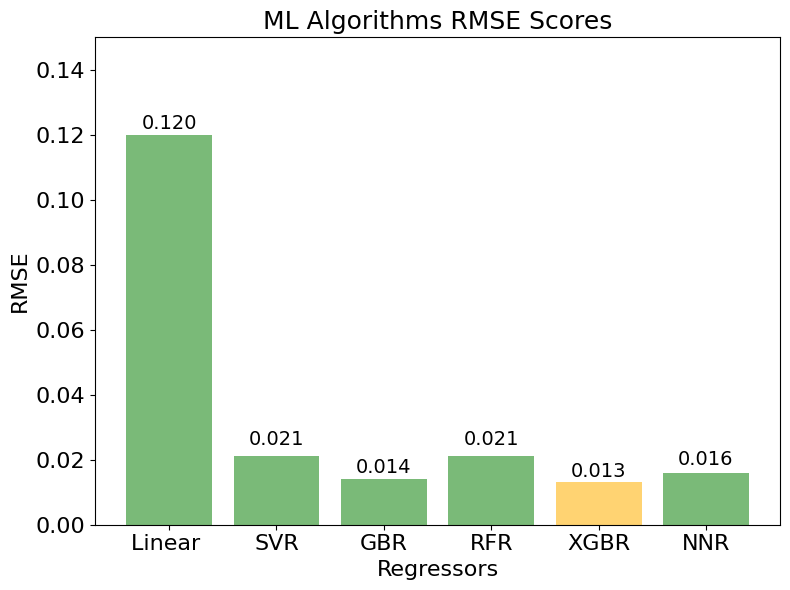

In [15]:
# Plotting R2 of all ML models
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

performance = results_df.iloc[:,7]

bar = ax.bar(model_names, performance,color=np.where(performance == min(performance),'#FFD372','#7ABA78'))
ax.set_xlabel('Regressors', fontsize=16)
ax.set_ylabel('RMSE', fontsize=16)
ax.set_title('ML Algorithms RMSE Scores', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if height >=0.01 and height <0.017:
            plt.text(rect.get_x()+0.5*rect.get_width(),1.25*height,'%.3f' % height,ha='center', va='center',fontsize=14)
        elif height >=0.017 and height <0.022:
            plt.text(rect.get_x()+0.5*rect.get_width(),1.25*height,'%.3f' % height,ha='center', va='center',fontsize=14)
        else:
            plt.text(rect.get_x()+0.5*rect.get_width(),1.03*height,'%.3f' % height,ha='center', va='center',fontsize=14)
autolabel(bar)

ax.set_ylim(0,0.15)

fig.tight_layout()
plt.show()

fig.savefig('plots/RMSE comparison plot.png', dpi=300, bbox_inches='tight')

From the above plots, it is clear that XGBR model is the best performing model. To understand their in-depth working on the data, SHAP and LIME analysis were performed.

## SHAP and LIME Analysis for the best model

In [13]:
# Extract the best parameters for XGBoost Regressor
params_xgbr = results_df.loc[results_df['Model'] == 'XGBR', 'Best Params'].values[0]
params_xgbr

"{'n_estimators': 10, 'learning_rate': 0.7225508524324976, 'max_depth': 10}"

In [14]:
# Defining StandardScaler for X and y
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Split the data into features (X) and response (y)
X = np.array(df_processed.iloc[:,:-1])
y = np.array(df_processed.iloc[:,-1])
# Convert y to 2D array if it's 1D
if len(y.shape) == 1:
    y = y.reshape(-1, 1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features and target variable
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

In [15]:
# Training the XGBoost Regressor with the best parameters
model_xgbr = XGBRegressor(**eval(params_xgbr))
model_xgbr.fit(X_train_scaled, y_train_scaled)

# Making predictions on the training and testing sets
y_pred_train_xgbr = y_scaler.inverse_transform(model_xgbr.predict(X_train_scaled).reshape(-1, 1)).ravel()
y_pred_test_xgbr = y_scaler.inverse_transform(model_xgbr.predict(X_test_scaled).reshape(-1, 1)).ravel()

## SHAP Analysis

In [19]:
# SHAP Analysis
# Initialize SHAP explainer and calculate SHAP values
explainer_xgbr = shap.TreeExplainer(model_xgbr)
shap_values = explainer_xgbr.shap_values(X_test_scaled)

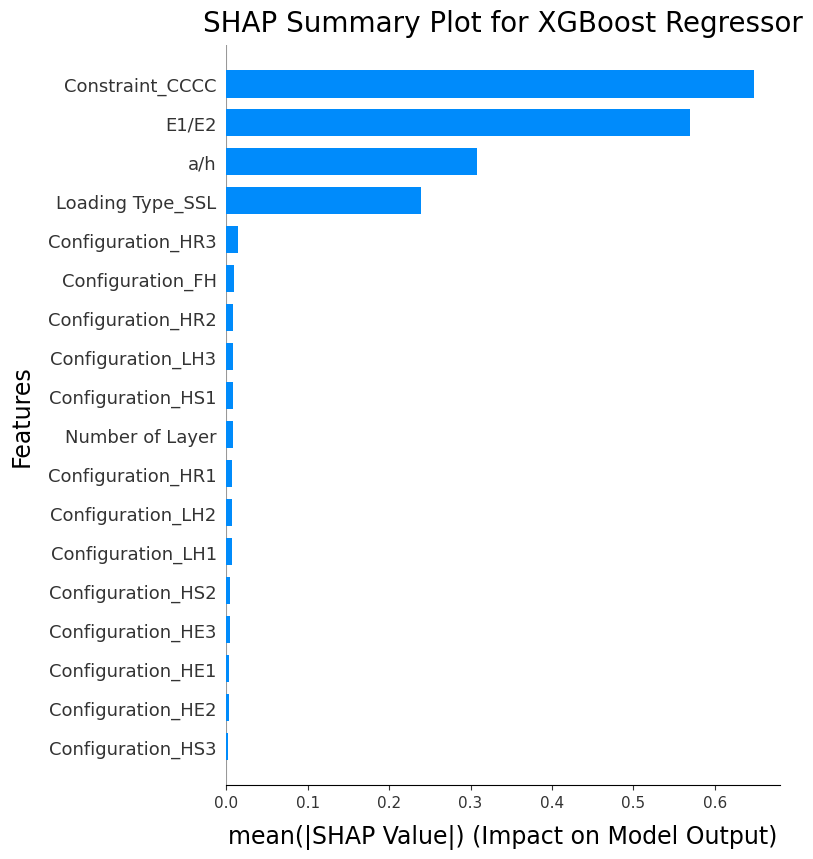

In [20]:
# SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=df_processed.columns[:-1], plot_type='bar', show=False)
# Adjusting the plot aesthetics
plt.xlabel("mean(|SHAP Value|) (Impact on Model Output)", fontsize=17, labelpad=10)
plt.ylabel("Features", fontsize=17, labelpad=10)
plt.title("SHAP Summary Plot for XGBoost Regressor", fontsize=20, pad=10)
plt.tight_layout()

# Save the SHAP summary plot
plt.savefig('plots/SHAP_summary_plot_xgbr.png', dpi=300, bbox_inches='tight')

plt.show()

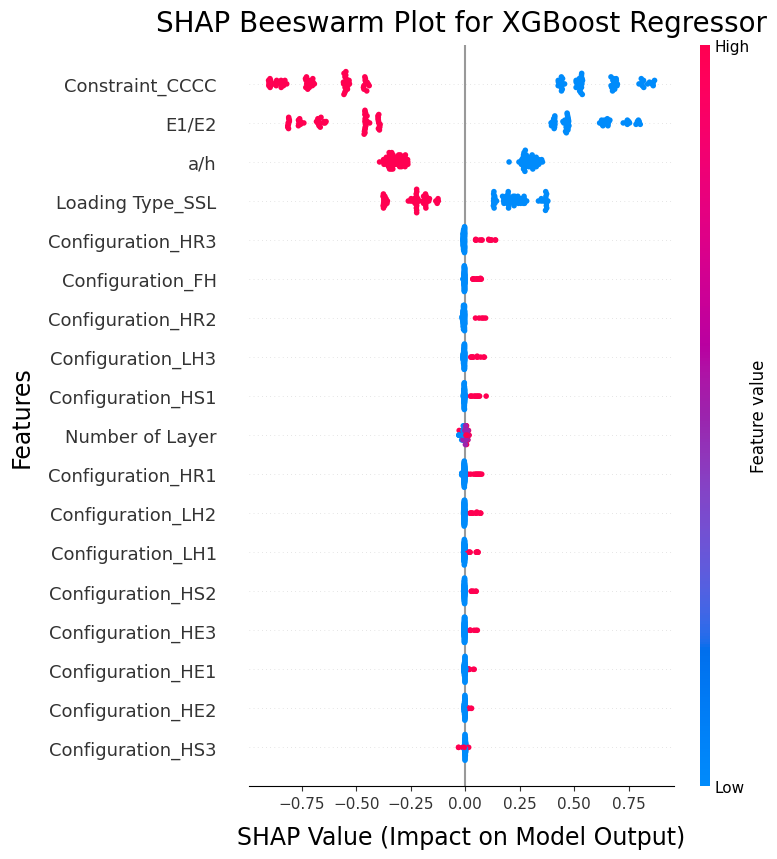

In [21]:
# SHAP beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, feature_names=df_processed.columns[:-1], show=False)
# Adjusting the plot aesthetics
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=17, labelpad=10)
plt.ylabel("Features", fontsize=17, labelpad=10)
plt.title("SHAP Beeswarm Plot for XGBoost Regressor", fontsize=20, pad=10)
plt.tight_layout()

# Save the SHAP summary plot
plt.savefig('plots/SHAP_beeswarm_plot_xgbr.png', dpi=300, bbox_inches='tight')

plt.show()

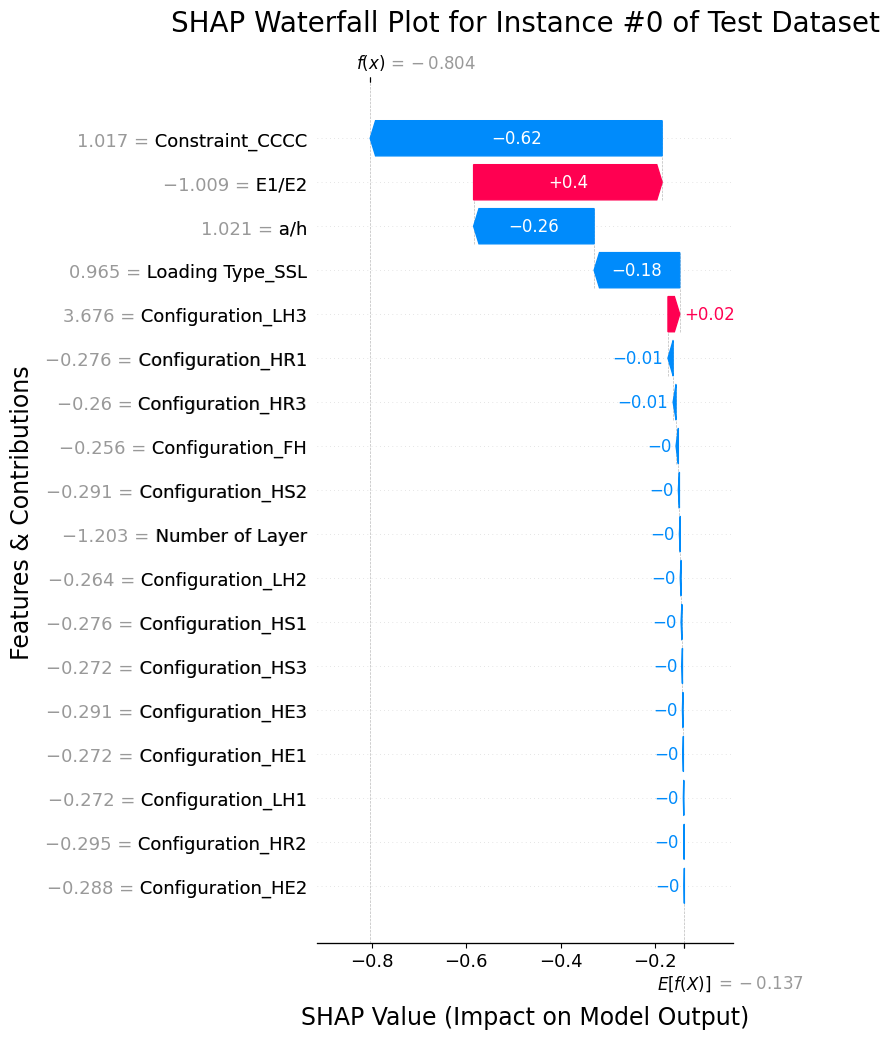

In [22]:
# SHAP waterfall plot

# Convert the scaled test data back to a DataFrame for SHAP visualization
features = df_processed.columns[:-1]  # Feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

# Initialize SHAP explainer and create explanation object for a specific instance
explainer_xgbr = shap.Explainer(model_xgbr, X_test_scaled_df, feature_names=features)
explanation = explainer_xgbr(X_test_scaled_df)

instance_idx = 0  # Index of the instance to explain

fig, ax = plt.subplots(figsize=(10, 6))

# Create SHAP waterfall plot for the specified instance
shap.plots.waterfall(explanation[instance_idx], max_display=20, show=False)

# Adjusting the plot aesthetics
ax.set_xlabel("SHAP Value (Impact on Model Output)", fontsize=17, labelpad=25)
ax.set_ylabel("Features & Contributions", fontsize=17, labelpad=8)
ax.set_title(f'SHAP Waterfall Plot for Instance #{instance_idx} of Test Dataset', fontsize=20, pad=15)
plt.tight_layout()

# Save the SHAP summary plot
plt.savefig('plots/SHAP_waterfall_plot_xgbr.png', dpi=300, bbox_inches='tight')

plt.show()

In [23]:
print("Real scaled deflection value: ", round(y_test_scaled[instance_idx][0],3))
print("Predicted scaled deflection value: ", round(model_xgbr.predict(X_test_scaled)[instance_idx],3))

Real scaled deflection value:  -0.817
Predicted scaled deflection value:  -0.804


In [24]:
print("Real deflection value: ", round(y_test[instance_idx][0],3))
print("Predicted deflection value: ", round(y_pred_test_xgbr[instance_idx],3))

Real deflection value:  0.243
Predicted deflection value:  0.247


In [25]:
X_test[0,:]

array([ 12,  10, 100,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1], dtype=int64)

## LIME Analysis

In [16]:
# Create the lime explainer for the XGBR model
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=df_processed.columns[:-1], class_names=['Deflection'], mode='regression')

In [17]:
# Get the exlplanation for the first instance in the test set
exp = lime_explainer.explain_instance(X_test_scaled[0], model_xgbr.predict, labels=df_processed.columns[:-1], num_features=X.shape[1], top_labels=1, num_samples=1000)

# Display the explanation
exp.show_in_notebook(show_table=True)

In [18]:
# Save the LIME explanation to an HTML file
exp.save_to_file('plots/lime_explanation_0.html')

In [19]:
# SAVE LIME EXPLANATION AS IMAGE
# Point to your local HTML file
html_path = os.path.abspath("plots/lime_explanation_0.html")
file_url  = "file://" + html_path

# Configure headless Chrome
options = Options()
options.add_argument("--headless")
options.add_argument("--window-size=1200,800")              # height must exceed full table

# Use Service() to pass the driver path
service = Service(ChromeDriverManager().install())
driver  = webdriver.Chrome(service=service, options=options)

# Load the page
driver.get(file_url)

# Locate the DIV (or whatever wrapper) that’s scrolling
# Inspect your HTML to find the right selector. Often LIME uses a div.table_div
scrollable_div = driver.find_element(By.CSS_SELECTOR, "div.table_div")

# 4) Expand it to show all rows
driver.execute_script("""const div = arguments[0];
                      div.style.height = div.scrollHeight + 'px';
                      div.style.overflow = 'visible';""", scrollable_div)

# Locate the table element and screenshot it
table = driver.find_element(By.TAG_NAME, "table")
table.screenshot("plots/lime_explanation_table.png")

# Capture the full viewport too
driver.save_screenshot("plots/lime_explanation_full.png")

driver.quit()

C:\Users\shakt\AppData\Local\Temp\ipykernel_30072\3616198094.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


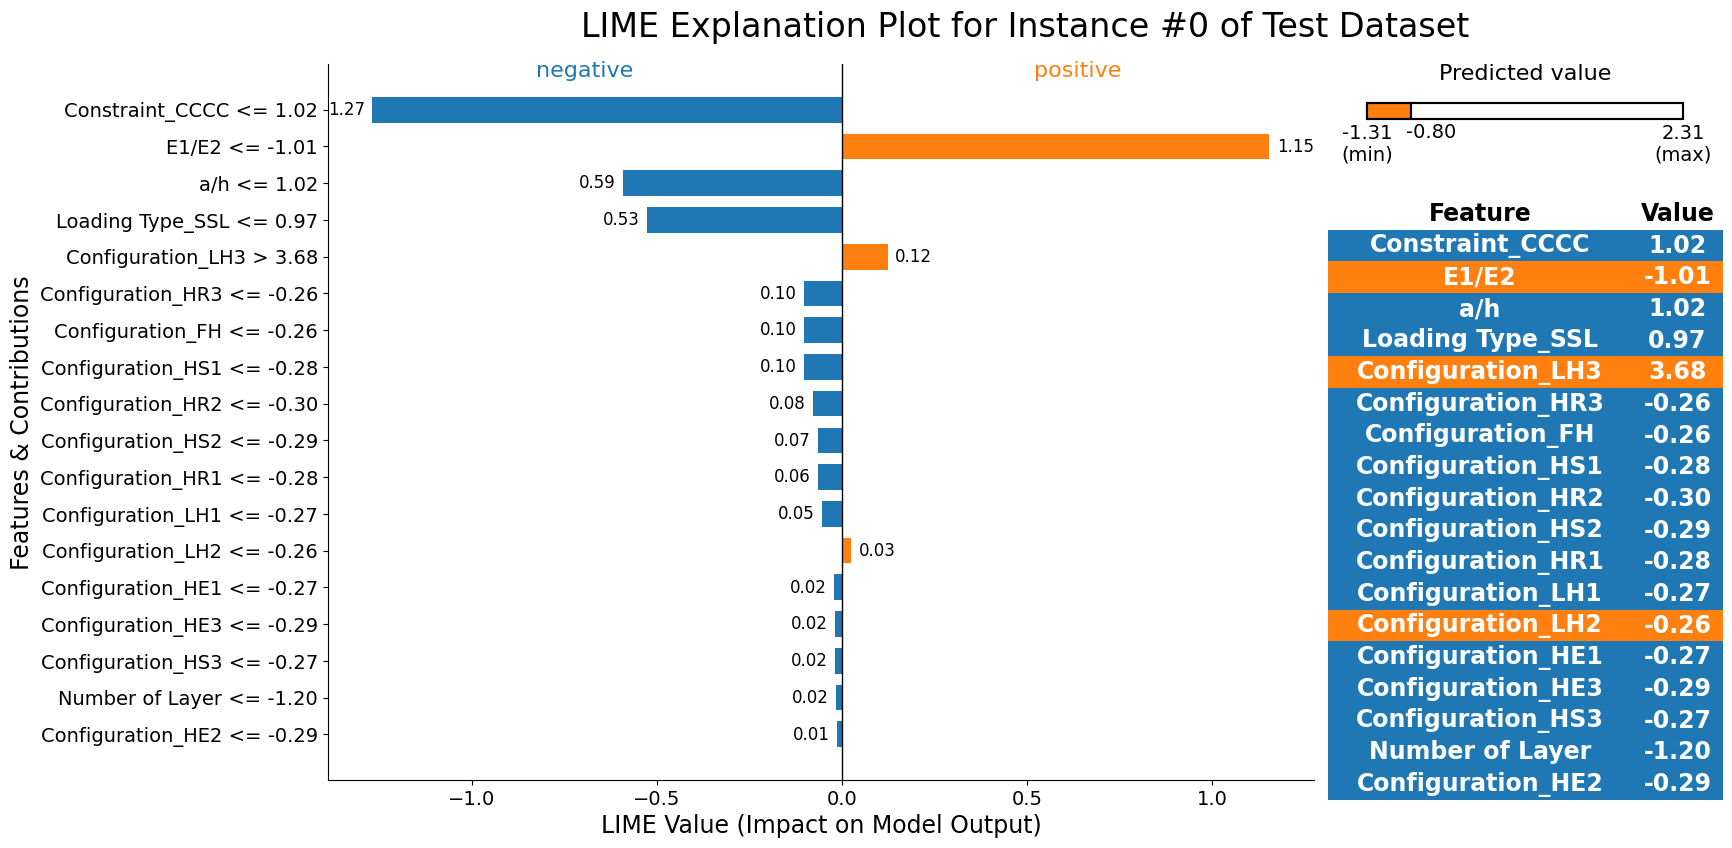

In [20]:
# Extract LIME explanation data
exp_list = exp.as_list()
feature_names_list = list(df_processed.columns[:-1])

# Map feature names to actual values from test instance
feature_value_map = {fname: X_test_scaled[0][i] for i, fname in enumerate(feature_names_list)}

# Parse features, conditions, and importance values
features, importances, conditions, actual_values = [], [], [], []
for feature_desc, importance in exp_list:
    # Split by all possible operators to find feature name
    # Handle range conditions like '-0.98 < Constraint_CCCC <= 1.02'
    # and single conditions like 'E1/E2 <= -1.01'
    
    # First, find the feature name by looking for patterns
    feature_name = feature_desc
    
    # Remove range prefix if exists (e.g., '-0.98 < ')
    if ' < ' in feature_name:
        parts = feature_name.split(' < ')
        if len(parts) > 1:
            feature_name = parts[1]
    
    # Remove suffix operators and values (e.g., ' <= 1.02' or ' <= -0.30')
    for op in [' <= ', ' >= ', ' < ', ' > ']:
        if op in feature_name:
            feature_name = feature_name.split(op)[0]
            break
    
    feature_name = feature_name.strip()
    
    # Get actual value from test instance
    actual_value = feature_value_map.get(feature_name, 0)
    
    # Create simplified condition showing only the relevant operator
    if '<=' in feature_desc:
        condition = f'<= {actual_value:.2f}'
    elif '>=' in feature_desc:
        condition = f'>= {actual_value:.2f}'
    elif '<' in feature_desc and '<=' not in feature_desc:
        condition = f'< {actual_value:.2f}'
    elif '>' in feature_desc and '>=' not in feature_desc:
        condition = f'> {actual_value:.2f}'
    else:
        condition = ''
    
    features.append(feature_name)
    importances.append(importance)
    conditions.append(condition)
    actual_values.append(actual_value)

# Get prediction values
prediction = exp.predicted_value
base_value = exp.min_value
max_value = exp.max_value

# Create figure with subplots
fig = plt.figure(figsize=(18, max(10, len(features) * 0.45)))
gs = fig.add_gridspec(2, 2, height_ratios=[0.5, 10], width_ratios=[3, 1.2], 
                       hspace=0.05, wspace=0.02)

# Title spanning both columns
ax_title = fig.add_subplot(gs[0, :])
ax_title.text(0.5, 0.5, 'LIME Explanation Plot for Instance #0 of Test Dataset', 
              ha='center', va='center', fontsize=24)
ax_title.axis('off')

# Left: Waterfall plot
ax_left = fig.add_subplot(gs[1, 0])
y_pos = np.arange(len(features))
colors = ['#ff800f' if imp > 0 else '#1f78b4' for imp in importances]
bars = ax_left.barh(y_pos, importances, color=colors, height=0.7)

# Add value labels on bars
for bar, imp in zip(bars, importances):
    width = bar.get_width()
    label_x = width + (0.02 if width > 0 else -0.02)
    ha = 'left' if width > 0 else 'right'
    ax_left.text(label_x, bar.get_y() + bar.get_height()/2, f'{abs(imp):.2f}', 
                 ha=ha, va='center', fontsize=12)

# Set y-axis labels with complete feature names and conditions
full_labels = [f"{feat} {cond}" for feat, cond in zip(features, conditions)]
ax_left.set_yticks(y_pos)
ax_left.set_yticklabels(full_labels, fontsize=14)
ax_left.tick_params(axis='x', labelsize=14)
ax_left.invert_yaxis()
ax_left.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax_left.set_xlabel('LIME Value (Impact on Model Output)', fontsize=17)
ax_left.set_ylabel('Features & Contributions', fontsize=17)

# Add negative/positive labels at top
xlim = ax_left.get_xlim()
ax_left.text(xlim[0] + (0 - xlim[0]) * 0.5, -0.9, 'negative', 
             ha='center', fontsize=16, color='#1f78b4')
ax_left.text(0 + (xlim[1] - 0) * 0.5, -0.9, 'positive', 
             ha='center', fontsize=16, color='#ff800f')

ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)

# Right: Combined prediction bar and feature table
ax_right = fig.add_subplot(gs[1, 1])
ax_right.axis('off')
ax_right.set_xlim(0, 2)
ax_right.set_ylim(-1, len(features) + 4)

# Predicted value section at top
pred_y = len(features) + 2.5
ax_right.text(1, pred_y + 1, 'Predicted value', ha='center', fontsize=16)

# Draw prediction bar
bar_width = 1.6
bar_height = 0.5
bar_x = 0.2

# Calculate filled portion based on prediction position
pred_range = max_value - base_value
filled_ratio = (prediction - base_value) / pred_range if pred_range != 0 else 0.5

# Orange filled portion
rect_filled = Rectangle((bar_x, pred_y - bar_height/2), 
                        bar_width * filled_ratio, bar_height, 
                        facecolor='#ff800f', edgecolor='black', linewidth=1.5)
ax_right.add_patch(rect_filled)

# White empty portion
rect_empty = Rectangle((bar_x + bar_width * filled_ratio, pred_y - bar_height/2), 
                       bar_width * (1-filled_ratio), bar_height, 
                       facecolor='white', edgecolor='black', linewidth=1.5)
ax_right.add_patch(rect_empty)

# Single border around entire bar
rect_border = Rectangle((bar_x, pred_y - bar_height/2), 
                        bar_width, bar_height, 
                        facecolor='none', edgecolor='black', linewidth=1.5)
ax_right.add_patch(rect_border)

# Add min/max labels
ax_right.text(bar_x, pred_y - 1.6, f'{base_value:.2f}\n(min)', 
              ha='center', fontsize=14)
ax_right.text(bar_x + bar_width, pred_y - 1.6, f'{max_value:.2f}\n(max)', 
              ha='center', fontsize=14)
ax_right.text(bar_x + filled_ratio*bar_width + 0.1, pred_y - 0.7, f'{prediction:.2f}', 
              ha='center', va='center', fontsize=14)

# Feature-Value table
# Create table data
table_data = [[feat, f'{val:.2f}'] for feat, val in zip(features, actual_values)]

# Create the table using plt.table
table = ax_right.table(cellText=table_data,
                       colLabels=['Feature', 'Value'],
                       cellLoc='center',
                       loc='center',
                       bbox=[0, -0.5/len(features), 1, (len(features)+0.5)/(len(features)+4)])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(17)
table.scale(1, 1.8)

# Color the cells based on importance and remove all borders
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)  # Remove all borders
    cell.set_edgecolor('none')
    
    row, col = key
    if row == 0:  # Header row
        cell.set_facecolor('#FFFFFF')
        cell.set_text_props(weight='bold', color='black')
    else:  # Data rows
        bg_color = '#ff800f' if importances[row-1] > 0 else '#1f78b4'
        cell.set_facecolor(bg_color)
        cell.set_text_props(color='white', weight='bold')

# Adjust column widths for exact fit
table.auto_set_column_width([0, 1])

# Save and show
plt.tight_layout()
plt.savefig('plots/lime_waterfall_complete.png', dpi=300, bbox_inches='tight')
plt.show()

### Aggregate LIME Weights

In [21]:
def return_weights(exp):
    """
    Function to get weights from LIME explanation object.
    Args:
        exp: LIME explanation object
    """
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]

    return exp_weight

In [22]:
weights = []

# Iterate through the test set and get weights for each instance
for i in range(len(X_test_scaled)):

    # Get the explanation for the i-th instance
    exp = lime_explainer.explain_instance(X_test_scaled[i], model_xgbr.predict, labels=df_processed.columns[:-1], num_features=X.shape[1])

    # Get the weights for the i-th instance
    weights.append(return_weights(exp))

# Convert weights to a DataFrame for easier manipulation
weights_df = pd.DataFrame(weights, columns=df_processed.columns[:-1])

In [23]:
weights_df.head()

,Number of Layer,E1/E2,a/h,Loading Type_SSL,Constraint_CCCC,Configuration_FH,Configuration_HE1,Configuration_HE2,Configuration_HE3,Configuration_HR1,Configuration_HR2,Configuration_HR3,Configuration_HS1,Configuration_HS2,Configuration_HS3,Configuration_LH1,Configuration_LH2,Configuration_LH3
0,-0.021639,1.134004,-0.578651,-0.493292,-1.236668,-0.067368,-0.026572,-0.021374,-0.046233,-0.032930,-0.074971,-0.093137,-0.047455,-0.004894,0.006210,-0.057569,-0.028854,0.075007
1,0.003468,-1.169202,-0.609352,0.494450,-1.238821,-0.082147,0.003024,0.048963,-0.022453,-0.078658,-0.082600,-0.104132,-0.073590,-0.074563,-0.004576,-0.036911,-0.056946,-0.079267
2,0.014266,-1.127066,0.587383,-0.479758,-1.219385,-0.086086,-0.003045,-0.025903,0.071787,-0.025357,-0.054341,-0.079864,-0.019753,-0.007339,-0.011608,-0.045448,-0.051560,-0.027240
3,-0.005774,1.159714,-0.582039,-0.500922,1.246387,-0.078958,-0.005727,-0.015988,-0.018033,-0.035830,-0.050495,-0.080418,-0.072274,-0.033378,-0.022039,0.039301,-0.058553,-0.042150
4,0.004540,-1.165353,-0.601799,0.482189,1.227223,-0.030972,0.005467,-0.048722,-0.031720,-0.048270,-0.087378,-0.088087,-0.063428,-0.035495,-0.010010,0.032881,-0.039083,-0.075794


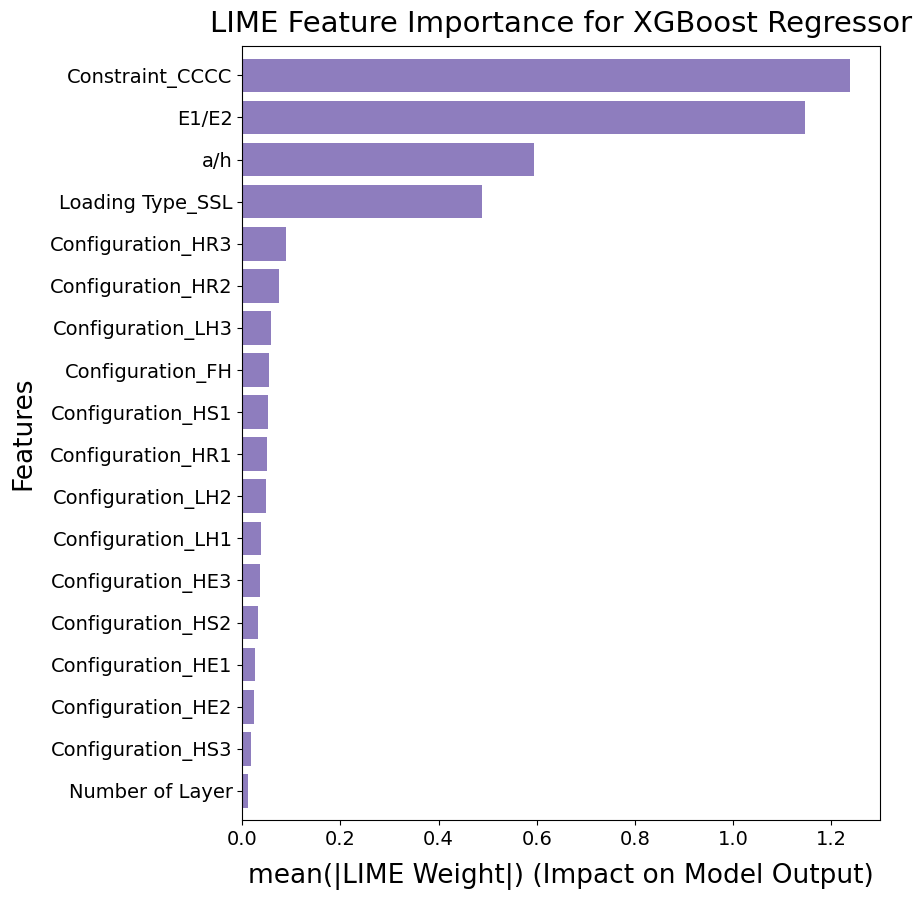

In [24]:
# Plotting LIME Summary Plot
# Get mean absolute weights for each feature
abs_mean_weights = weights_df.abs().mean()
abs_mean_weights = pd.DataFrame(data={'Feature': abs_mean_weights.index, 'Abs_Mean': abs_mean_weights})
abs_mean_weights = abs_mean_weights.sort_values('Abs_Mean')

# Plotting mean absolute weights

y_ticks = range(len(abs_mean_weights))
y_labels = abs_mean_weights.Feature

fig, ax = plt.subplots(figsize=(9, len(y_labels)*0.45 + 1))

plt.barh(y_ticks, abs_mean_weights.Abs_Mean, color='#8E7DBE')
plt.yticks(y_ticks, y_labels, fontsize=14)
plt.ylim(-0.7, len(y_labels)-0.3)
plt.xticks(fontsize=14)
plt.ylabel('Features', fontsize=19, labelpad=10)
plt.xlabel('mean(|LIME Weight|) (Impact on Model Output)', fontsize=19, labelpad=10)
plt.title('LIME Feature Importance for XGBoost Regressor', fontsize=21, pad=10)
plt.tight_layout()

# Save the LIME summary plot
plt.savefig('plots/LIME_summary_plot_xgbr.png', dpi=300, bbox_inches='tight')

plt.show()

In [25]:
pd.DataFrame(X_test_scaled, columns=df_processed.columns[:-1])

,Number of Layer,E1/E2,a/h,Loading Type_SSL,Constraint_CCCC,Configuration_FH,Configuration_HE1,Configuration_HE2,Configuration_HE3,Configuration_HR1,Configuration_HR2,Configuration_HR3,Configuration_HS1,Configuration_HS2,Configuration_HS3,Configuration_LH1,Configuration_LH2,Configuration_LH3
0,-1.203065,-1.009355,1.020698,0.965223,1.016903,-0.255883,-0.272029,-0.287509,-0.291288,-0.275957,-0.295033,-0.259989,-0.275957,-0.291288,-0.272029,-0.272029,-0.264048,3.676073
1,1.272207,0.990732,1.020698,-1.036030,1.016903,-0.255883,-0.272029,3.478155,-0.291288,-0.275957,-0.295033,-0.259989,-0.275957,-0.291288,-0.272029,-0.272029,-0.264048,-0.272029
2,1.272207,0.990732,-0.979721,0.965223,1.016903,-0.255883,-0.272029,-0.287509,3.433033,-0.275957,-0.295033,-0.259989,-0.275957,-0.291288,-0.272029,-0.272029,-0.264048,-0.272029
3,1.272207,-1.009355,1.020698,0.965223,-0.983378,-0.255883,-0.272029,-0.287509,-0.291288,-0.275957,-0.295033,-0.259989,-0.275957,-0.291288,-0.272029,3.676073,-0.264048,-0.272029
4,0.034571,0.990732,1.020698,-1.036030,-0.983378,-0.255883,-0.272029,-0.287509,-0.291288,-0.275957,-0.295033,-0.259989,-0.275957,-0.291288,-0.272029,3.676073,-0.264048,-0.272029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.034571,0.990732,-0.979721,0.965223,1.016903,-0.255883,-0.272029,-0.287509,-0.291288,3.623752,-0.295033,-0.259989,-0.275957,-0.291288,-0.272029,-0.272029,-0.264048,-0.272029
131,-1.203065,0.990732,1.020698,0.965223,-0.983378,-0.255883,-0.272029,-0.287509,-0.291288,-0.275957,-0.295033,-0.259989,3.623752,-0.291288,-0.272029,-0.272029,-0.264048,-0.272029
132,-1.203065,0.990732,1.020698,-1.036030,-0.983378,-0.255883,-0.272029,-0.287509,-0.291288,-0.275957,-0.295033,3.846312,-0.275957,-0.291288,-0.272029,-0.272029,-0.264048,-0.272029
133,-1.203065,-1.009355,1.020698,-1.036030,1.016903,-0.255883,-0.272029,3.478155,-0.291288,-0.275957,-0.295033,-0.259989,-0.275957,-0.291288,-0.272029,-0.272029,-0.264048,-0.272029


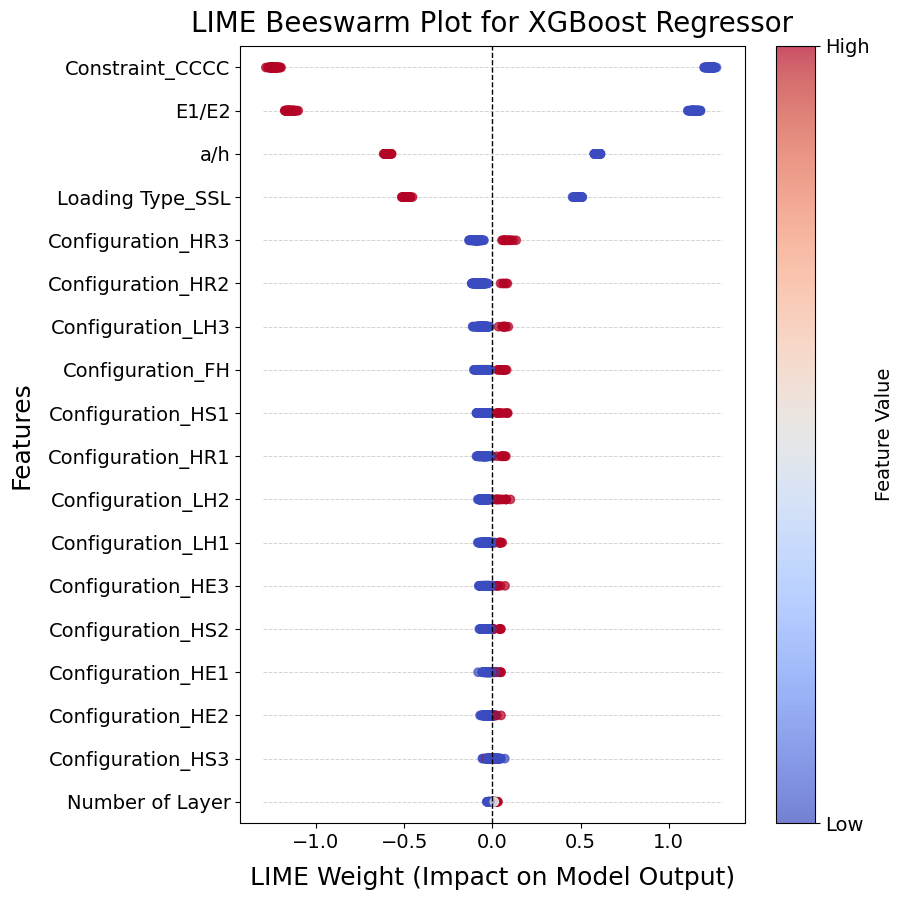

In [26]:
# Plotting LIME Beeswarm Plot

y_ticks = list(range(len(abs_mean_weights)))
y_labels = abs_mean_weights.Feature.tolist()

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=df_processed.columns[:-1])

fig = plt.subplots(figsize=(9, len(y_labels)*0.45 + 1))

for y in y_ticks:
    plt.hlines(y, xmin=-1.3, xmax=1.3, color='lightgrey', linestyle='--', linewidth=0.7, zorder=0)

# Plotting the beeswarm plot
for i, feature in enumerate(y_labels):

    feature_weight = weights_df[feature].values
    feature_value = X_test_scaled_df[feature].values

    plt.scatter(feature_weight, [i]*len(feature_weight),
                c=feature_value, cmap='coolwarm', alpha=0.7, zorder=1)

plt.vlines(0, ymin=-0.5, ymax=len(y_labels)-0.5, color='black', linestyle='--', linewidth=1)

cbar = plt.colorbar()
cbar.set_label('Feature Value', fontsize=14)
cbar.set_ticks([np.min(feature_value), np.max(feature_value)])
cbar.set_ticklabels(['Low', 'High'], fontsize=14)


plt.yticks(y_ticks, y_labels, fontsize=14)
plt.ylim(-0.5, len(y_labels)-0.5)
plt.xticks(fontsize=14)
plt.ylabel('Features', fontsize=18, labelpad=10)
plt.xlabel('LIME Weight (Impact on Model Output)', fontsize=18, labelpad=10)
plt.title('LIME Beeswarm Plot for XGBoost Regressor', fontsize=20, pad=10)
plt.tight_layout()

# Save the LIME beeswarm plot
plt.savefig('plots/LIME_beeswarm_plot_xgbr.png', dpi=300, bbox_inches='tight')

plt.show()